# 4.6.4 보팅 앙상블 손글씨 분류

##kNN, SVM, 의사결정트리의 3가지 모델을 앙상블하여 더 나은 예측 실행하기
###"배깅(Bagging) = 부트스트랩(Bootstrap) + 어그리게이팅(Aggregating)" 중에서 어그리게이팅만 실행하는 예제임.

In [ ]:
from sklearn import datasets   # 사이킷런의 MNIST 손글씨 데이터 간략화 버전(8x8) 사용
from sklearn import tree         # 의사결정트리 실행
from sklearn.neighbors import KNeighborsClassifier   # kNN 실행
from sklearn.svm import SVC  # 서포트 벡터 머신(SVM) 실행
from sklearn.ensemble import VotingClassifier     # 보팅(voting) 실행
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## 손글씨 데이터 불러오기

In [ ]:
mnist = datasets.load_digits()   # 사이킷런의 MNIST 손글씨(숫자) 데이터 불러오기
features, labels = mnist.data, mnist.target   # 학습 데이터와 레이블 데이터 분리

# ★★학습 데이터(80%)와 테스트 데이터(20%)로 분리★★
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)  
# 총 숫자 개수: 1,797개 -> 학습 데이터 1,438개, 테스트 데이터 359개.

## 단일 모델의 정확도 측정

In [ ]:
# 의사결정트리 학습 및 테스트                                                       # 분류 때 사용하는 특징 최대 수  
dtree = tree.DecisionTreeClassifier(criterion="gini", max_depth=8, max_features=32, random_state=35)
dtree = dtree.fit(X_train, y_train)                        # 트리 최대 깊이
dtree_predicted = dtree.predict(X_test)

# kNN 학습 및 테스트
knn = KNeighborsClassifier(n_neighbors=299).fit(X_train, y_train)  # 주변 299명에게 물어보겠다?? but 5로 하면 정확도 확 올라감.
knn_predicted = knn.predict(X_test)

# SVM 학습 및 테스트                                              # 랜덤 seed 값은 정확한 비교를 위해 위의 의사결정트리꺼와 동일한 값으로 설정
svm = SVC(C=0.1, gamma=0.003, probability=True, random_state=35).fit(X_train, y_train)
svm_predicted = svm.predict(X_test)   # probability : 확률 계산을 수행할지 여부. 하드/소프트 보팅을 수행하기 위해서 True로 설정해야 함

print("[정확도]")
print("의사결정트리 : %.2f" %(accuracy_score(y_test, dtree_predicted)*100) + "%")
print("kNN : %.2f" %(accuracy_score(y_test, knn_predicted)*100) + "%")
print("SVM : %.2f" %(accuracy_score(y_test, svm_predicted)*100) + "%")

[정확도]
의사결정트리 : 78.06%
kNN : 81.67%
SVM : 93.61%


In [ ]:
# 사이킷런의 VotingClassifier를 사용하지 않고 SVM의 직접 분류값별 확률 확인해 보기
svm_proba = svm.predict_proba(X_test)
print(svm_proba[0:2])  # 테스트 데이터 첫 번째꺼부터 2개까지만 출력

[[1.58395116e-03 9.08912353e-01 6.40327542e-03 2.57131907e-03
  6.98038546e-03 7.25001435e-03 1.85366151e-03 6.01827991e-03
  4.50836785e-02 1.33430816e-02]
 [8.40227841e-04 5.09691987e-03 9.54968983e-01 1.71009633e-03
  2.71941326e-03 3.39491297e-03 9.21041164e-04 2.83198680e-03
  2.34335952e-02 4.08282375e-03]]


## 하드 보팅

In [ ]:
# 학습 데이터에 대해 학습 실행
voting_clf = VotingClassifier(estimators=[('decision_tree', dtree), ('knn', knn), ('svm', svm)], 
                                          weights=[1,1,1], voting='hard').fit(X_train, y_train)
# 테스트 데이터에 대한 예측 실행
hard_voting_predicted = voting_clf.predict(X_test)   
print("하드 보팅 정확도 : %.2f" %(accuracy_score(y_test, hard_voting_predicted)*100) + "%")

하드 보팅 정확도 : 90.56%


## 소프트 보팅

In [ ]:
# 학습 데이터에 대해 학습 실행
voting_clf = VotingClassifier(estimators=[('decision_tree', dtree), ('knn', knn), ('svm', svm)], 
                                          weights=[1,1,1], voting='soft').fit(X_train, y_train)
# 테스트 데이터에 대한 예측 실행
soft_voting_predicted = voting_clf.predict(X_test)   
print("소프트 보팅 정확도 : %.2f" %(accuracy_score(y_test, soft_voting_predicted)*100) + "%")

소프트 보팅 정확도 : 85.28%


## 정확도 비교 시각화

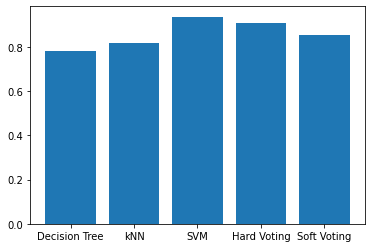

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x = np.arange(5)  # 0부터 5개 숫자들을 array 형태로 반환. 즉 [0, 1, 2, 3, 4]
plt.bar(x, height= [accuracy_score(y_test, dtree_predicted),
                            accuracy_score(y_test, knn_predicted),
                            accuracy_score(y_test, svm_predicted),
                            accuracy_score(y_test, hard_voting_predicted),
                            accuracy_score(y_test, soft_voting_predicted)])
plt.xticks(x, ['Decision Tree', 'kNN', 'SVM', 'Hard Voting', 'Soft Voting']);